In [1]:
import os 
import pickle
import numpy as np
import pandas as pd
from datetime import date, timedelta

import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', None)

## Load Data

In [2]:
path = '../data/processed'

# customers
customers = pd.read_pickle(os.path.join(path,'customers.pkl'))


# articles description
articles = pd.read_pickle(os.path.join(path,'articles.pkl'))

# transaction
df = pd.read_pickle(os.path.join(path,'transactions.pkl'))

# random_list = pd.read_csv('../data/random_customer.csv')
# df = df[df.customer_id.isin(random_list.customer_id)].reset_index(drop=True)  # Select random cus

# print('First t_dat: ', df[df.customer_id.isin(random_list.customer_id)]['t_dat'].min())
# print('Last t_dat: ', df[df.customer_id.isin(random_list.customer_id)]['t_dat'].max())
# print('Total Transactions: ', len(df))
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,2,0663713001,0.0508,2
1,2018-09-20,2,0541518023,0.0305,2
2,2018-09-20,7,0505221004,0.0152,2
3,2018-09-20,7,0685687003,0.0169,2
4,2018-09-20,7,0685687004,0.0169,2


## Procedure
- find similar users or items
- predict the ratings of the items that are not yet rated by a user

<b>Answers to these questions:</b>
- How do you determine which users or items are similar to one another?
- Given that you know which users are similar, how do you determine the rating that a user would give to an item based on the ratings of similar users?
- How do you measure the accuracy of the ratings you calculate?

<br><b>Keep in mind!!</b>
- The similarity is not calculated using factors like the age of users, genre of the movie, or any other data about users or items. 
- It is <u>calculated only on the basis of the rating</u> (explicit or implicit) a user gives to an item. 
- For example, two users can be considered similar if they give the same ratings to ten movies despite there being a big difference in their age.

## Data Transfromation

In [3]:
temp = df[df.t_dat<'2020-09-15']\
            .groupby(['customer_id','article_id'])\
            .agg({'article_id':'count'})\
            .rename(columns={'article_id':'quantity'})\
            .reset_index()

temp['quantity'] = temp['quantity'].clip(0,5)
temp['quantity'] = temp['quantity'].astype('int8')
print(len(temp))
temp.describe(percentiles=[0.1,0.5,0.99])
temp.head()

27079047


,customer_id,article_id,quantity
0,0,0176209023,1
1,0,0568601006,2
2,0,0568601043,1
3,0,0607642008,1
4,0,0625548001,1


In [ ]:
# Pivot
temp = temp.pivot_table(index='customer_id', columns='article_id', values='quantity',aggfunc=np.sum)
# print('Matrix Sparsity: ', np.sum(colla_df.count())/(colla_df.shape[0]*colla_df.shape[1]))
temp.head()

## Matrix Factorization

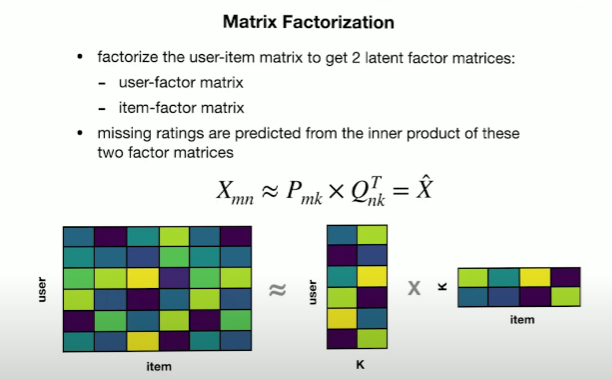

In [ ]:
import implicit
from scipy.sparse import csr_matrix, coo_matrix
from implicit.evaluation import mean_average_precision_at_k

In [ ]:
from scipy.sparse import csr_matrix, coo_matrix

df = df[df['t_dat'] >'2020-09-20']

ALL_USERS = customers['customer_id'].unique().tolist()
ALL_ITEMS = articles['article_id'].unique().tolist()

user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

df['user_id'] = df['customer_id'].map(user_map)
df['item_id'] = df['article_id'].map(item_map)


row = df['user_id'].values
col = df['item_id'].values
data = np.ones(df.shape[0])
coo_train = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
coo_train

In [ ]:
# Save COO Matrix
import scipy
scipy.sparse.save_npz('coo_train.npz', coo_train)
sparse_matrix = scipy.sparse.load_npz('coo_train.npz')
sparse_matrix

In [ ]:
test = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)
test.head()

In [29]:
model = implicit.als.AlternatingLeastSquares(factors=10, iterations=2)
model.fit(coo_train)

C:\Users\praka\Anaconda3\lib\site-packages\implicit\utils.py:31: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
def to_user_item_coo(df):
    """ Turn a dataframe with transactions into a COO sparse items x users matrix"""
    row = df['user_id'].values
    col = df['item_id'].values
    data = np.ones(df.shape[0])
    coo = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
    return coo


def split_data(df, validation_days=7):
    """ Split a pandas dataframe into training and validation data, using <<validation_days>>
    """
    validation_cut = df['t_dat'].max() - pd.Timedelta(validation_days)

    df_train = df[df['t_dat'] < validation_cut]
    df_val = df[df['t_dat'] >= validation_cut]
    return df_train, df_val

def get_val_matrices(df, validation_days=7):
    """ Split into training and validation and create various matrices
        
        Returns a dictionary with the following keys:
            coo_train: training data in COO sparse format and as (users x items)
            csr_train: training data in CSR sparse format and as (users x items)
            csr_val:  validation data in CSR sparse format and as (users x items)
    
    """
    df_train, df_val = split_data(df, validation_days=validation_days)
    coo_train = to_user_item_coo(df_train)
    coo_val = to_user_item_coo(df_val)

    csr_train = coo_train.tocsr()
    csr_val = coo_val.tocsr()
    
    return {'coo_train': coo_train,
            'csr_train': csr_train,
            'csr_val': csr_val
          }


def validate(matrices, factors=200, iterations=20, regularization=0.01, show_progress=True):
    """ Train an ALS model with <<factors>> (embeddings dimension) 
    for <<iterations>> over matrices and validate with MAP@12
    """
    coo_train, csr_train, csr_val = matrices['coo_train'], matrices['csr_train'], matrices['csr_val']
    
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    
    # The MAPK by implicit doesn't allow to calculate allowing repeated items, which is the case.
    # TODO: change MAP@12 to a library that allows repeated items in prediction
    map12 = mean_average_precision_at_k(model, csr_train, csr_val, K=12, show_progress=show_progress, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@12: {map12:6.5f}")
    return map12

In [31]:
matrices = get_val_matrices(df)

## Hyperparameter Tuning

In [ ]:
best_map12 = 0
for factors in [40, 50, 60, 100, 200, 500, 1000]:
    for iterations in [3, 12, 14, 15, 20]:
        for regularization in [0.01]:
            map12 = validate(matrices, factors, iterations, regularization, show_progress=False)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

Factors:  40 - Iterations:  3 - Regularization: 0.010 ==> MAP@12: 0.00298
Best MAP@12 found. Updating: {'factors': 40, 'iterations': 3, 'regularization': 0.01}
Factors:  40 - Iterations: 12 - Regularization: 0.010 ==> MAP@12: 0.00368
Best MAP@12 found. Updating: {'factors': 40, 'iterations': 12, 'regularization': 0.01}
Factors:  40 - Iterations: 14 - Regularization: 0.010 ==> MAP@12: 0.00371
Best MAP@12 found. Updating: {'factors': 40, 'iterations': 14, 'regularization': 0.01}
Factors:  40 - Iterations: 15 - Regularization: 0.010 ==> MAP@12: 0.00373
Best MAP@12 found. Updating: {'factors': 40, 'iterations': 15, 'regularization': 0.01}
Factors:  40 - Iterations: 20 - Regularization: 0.010 ==> MAP@12: 0.00365
Factors:  50 - Iterations:  3 - Regularization: 0.010 ==> MAP@12: 0.00314
Factors:  50 - Iterations: 12 - Regularization: 0.010 ==> MAP@12: 0.00370
Factors:  50 - Iterations: 14 - Regularization: 0.010 ==> MAP@12: 0.00370
Factors:  50 - Iterations: 15 - Regularization: 0.010 ==> MAP

## Training

In [ ]:
coo_train = to_user_item_coo(df)
csr_train = coo_train.tocsr()

In [ ]:
def train(coo_train, factors=200, iterations=15, regularization=0.01, show_progress=True):
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    return model

In [ ]:
best_params

In [ ]:
model = train(coo_train, **best_params)

## Submission

In [ ]:
def submit(model, csr_train, submission_name="submissions.csv"):
    preds = []
    batch_size = 2000
    to_generate = np.arange(len(ALL_USERS))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx : startidx + batch_size]
        ids, scores = model.recommend(batch, csr_train[batch], N=12, filter_already_liked_items=False)
        for i, userid in enumerate(batch):
            customer_id = user_ids[userid]
            user_items = ids[i]
            article_ids = [item_ids[item_id] for item_id in user_items]
            preds.append((customer_id, ' '.join(article_ids)))

    df_preds = pd.DataFrame(preds, columns=['customer_id', 'prediction'])
    df_preds.to_csv(submission_name, index=False)
    
    display(df_preds.head())
    print(df_preds.shape)
    
    return df_preds

In [ ]:
df_preds = submit(model, csr_train)


In [ ]:
import pickle
# mapping index
path = '../data/processed'

infile = open(os.path.join(path,'index_to_cusId.pkl'),'rb')
index_to_id_dict = pickle.load(infile)
infile.close()
df_preds["customer_id"] = df_preds["customer_id"].map(index_to_id_dict)
df_preds.head()

In [ ]:
df_preds.to_csv('submissions.csv',index=False)